In [1]:
# license: GPL v3
# authors: Michael Olesik, Piotr Bartman, Sylwester Arabas
# copyright: Jagiellonian University
# based on Fig. 2 from Yang et al. 2018 (http://dx.doi.org/10.5194/acp-18-7313-2018)

In [2]:
# make local files accessible to import statements
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))
from PySDM_tests.smoke_tests.utils import bdf

In [3]:
from PySDM_examples.Yang_et_al_2018_Fig_2.example import Simulation
from PySDM_examples.Yang_et_al_2018_Fig_2.setup import Setup
from PySDM.physics import formulae as phys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})
from PySDM_examples.utils.show_plot import show_plot

In [4]:
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [5]:
ix51 = 40
ix503 = 99

In [6]:
schemes = ['default','non_adaptive', 'BDF']
# schemes = ['default']

In [7]:
def runner(scheme='BDF'):
    assert scheme in ['default','non_adaptive','BDF']
    setup = Setup(dt_output = 60*10*si.second)
    if scheme == 'non_adaptive':
        setup.adaptive = False
        setup.dt_max = .5 #* si.second
    
    assert round(setup.r_dry[  ix51]*1e9, 0) == 51
    assert round(setup.r_dry[ ix503]*1e9, 0) == 503

#     setup.rtol_thd = 1e-7
    setup.rtol_x = 1e-3
    # setup.dt_max = .5
    

    simulation = Simulation(setup)
    if scheme == 'BDF':
        rtol_bdf = 1e-4
        bdf.patch_particles(simulation.particles, setup.coord, rtol=rtol_bdf)

        
    output = simulation.run()
    result = {}
    
    result['r_bins_values'] = np.array(output['r_bins_values']).T / (setup.mass_of_dry_air)
    result['r_bins_edges'] = setup.r_bins_edges
    
    result['r'] = np.array(output['r']).T * si.metres
    result['t'] = output["t"] * si.seconds
    result['z'] = output["z"] * si.metres
    result['S'] = np.array(output["S"]) * si.dimensionless
    result['q'] = (setup.q0 - np.array(output["qv"])) * si.kilogram / si.kilogram
    result['T'] = np.array(output["T"])
    result['n'] = setup.n / (setup.mass_of_dry_air * si.kilogram)
    result['dt_max'] = setup.dt_max
    result['dt_cond_max'] = output['dt_cond_max']
    result['dt_cond_min'] = output['dt_cond_min']
    
    result['r_dry'] = setup.r_dry
    result['kappa'] = setup.kappa
    
    if scheme in ['default', 'non_adaptive']:
        result['rtol_x'] = setup.rtol_x
        result['rtol_thd'] = setup.rtol_thd
    if scheme == 'BDF':
        result['rtol_bdf'] = rtol_bdf
    
    arg_T = result['T'].reshape(-1,1).repeat(len(result['n']), axis = 1)
    result['r_cr'] = phys.r_cr(setup.kappa, setup.r_dry, arg_T).transpose()
    result['ripening_flags'] = output['ripening_flags']
    return  result

In [8]:
outputs = []
for scheme in schemes:
    outputs.append(runner(scheme))

C:\Users\Michael\PycharmProjects\PySDM\PySDM_examples\Yang_et_al_2018_Fig_2\../..\PySDM\dynamics\condensation\products\condensation_timestep.py:50: RuntimeWarning: divide by zero encountered in true_divide
  self.buffer[:] = self.condensation.particles.dt / self.buffer


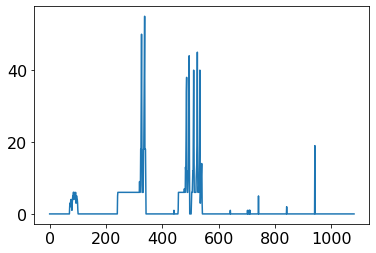

In [9]:
plt.step(outputs[0]['ripening_flags'])

In [10]:
figsize = (14,9*len(outputs))

In [11]:
fig, ax = plt.subplots(len(schemes), 3, sharey=True, figsize=figsize)
if len(outputs)==1:
    ax = np.array(ax).reshape(len(outputs),3)
for i, output in enumerate(outputs):
    dt_max = output['dt_max']
    if i==2:
#         rtol = rtol_bdf
        rtol = 1e-4 # TODO
        tols = f'tolerance = {rtol}'
    else:
        rtol_x = output['rtol_x']
        rtol_thd = output['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
        
    ax[i,1].set_title('Scheme: '+f'({schemes[i]}) \n dt_max = {dt_max}, '+tols)
    
    ax[i,0].set_ylim([800, 1300])
    ax[i,0].plot(output['q'], output['z'], label="q$_l$")
    ax[i,0].xaxis.set_units(si.gram / si.kilogram)
    ax[i,0].grid()
    ax[i,0].legend(loc='best')

    ax[i,1].plot(output['S']+1, output['z'], label="S+1")
    ax[i,1].grid()
    ax[i,1].legend(loc='best')
    ax[i,1].set_xlim([0.997, 1.003])

    ax[i,2].plot(output['r'][ix51], output['z'], label="r$_d$ = 51 nm")
    ax[i,2].plot(output['r'][ix503], output['z'], label="r$_d$ = 501 nm")
    ax[i,2].grid()
    ax[i,2].xaxis.set_units(si.micrometre)
    ax[i,2].legend(loc='best')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

    

show_plot(filename='q_S_rd.pdf')

In [12]:
def rmean(r, n, mask): # TODO: move to products
    nt = r.shape[1]
    n_dot_r = n.magnitude.dot(np.where(mask, r.magnitude, 0))
    n_tot = np.sum(np.where(mask, n.magnitude.reshape(-1,1).repeat(nt, axis=1), 0), axis=0)
    rmean = np.full(nt, np.nan)
    nmask = n_tot > 0
    rmean[nmask] = n_dot_r[nmask] / n_tot[nmask]
    return rmean * r.units

In [13]:
mgn = lambda value, unit: (value / unit).to_base_units().magnitude

fig, ax = plt.subplots(len(schemes), 1, sharex=True, figsize=figsize)
if len(outputs)==1:
    ax = (ax,)
for i, output in enumerate(outputs):
    dt_max = output['dt_max']
    if i==2:
        rtol = output['rtol_bdf']
        tols = f'tolerance = {rtol}'
    else:
        rtol_x = output['rtol_x']
        rtol_thd = output['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
    
    hist = output['r_bins_values']
    xedges = output['t'].magnitude
    yedges = output['r_bins_edges']
    
    xunit = si.hour
    yunit = si.micrometres
#     t0 = time.time() # TODO for test

    c = ax[i].pcolormesh(
        mgn(xedges * output['t'].units, xunit), 
        mgn(yedges * output['r'].units, yunit), 
        hist,
        cmap = 'coolwarm',
        norm = mpl.colors.LogNorm()
    )
    ax[i].set_title('Scheme: '+f'({schemes[i]}) \n dt_max = {dt_max}, '+tols)
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)
    ax[i].set_ylim([0, 20])

    ax[i].plot(output['t'], rmean(output['r'], output['n'], output['r'].magnitude > output['r_cr']), label="r_mean (r > r_cr)", color='black')
    ax[i].plot(output['t'], rmean(output['r'], output['n'], output['r'] > 1 * si.micrometre), label="r_mean (r > 1 um)", linestyle='--', color='gray')
    ax[i].legend(loc='best')
    ax[i].grid()
#     t1 = time.time() # TODO for test
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
#     print(t1-t0) # TODO: for test
show_plot(filename='spectrum.pdf')

In [14]:
def rel_dispersion(r, n, mask):  # TODO: move to products
    mean = rmean(r, n, mask)
    n_tot = np.sum(np.where(mask, n.magnitude.reshape(-1,1).repeat(r.shape[1], axis=1), 0), axis=0)
    std = np.full(r.shape[1], np.nan)
    nmask = n_tot > 0
    argument = n.magnitude.dot(np.where(mask, np.power(r.magnitude - mean.magnitude, 2), 0))
    std[nmask] = np.sqrt(argument[nmask] /n_tot[nmask])
    return std / mean.magnitude

In [15]:
def measure(outputs):
    bdf = outputs['bdf']
    default = outputs['default']
    
    rel_bdf = rel_dispersion(bdf['r'],bdf['n'],bdf['r'].magnitude > bdf['r_cr'])
    rel_def = rel_dispersion(default['r'], default['n'], default['r'] > default['r_cr'])
    return (rel_bdf - rel_def) / rel_bdf

In [27]:
fig, ax = plt.subplots(len(schemes), 1, sharex=True, figsize=figsize)
if len(outputs)==1:
    ax = (ax,)
for i, output in enumerate(outputs):
    dt_max = output['dt_max']
    if i==2:
        rtol = output['rtol_bdf']
        tols = f'tolerance = {rtol}'
    else:
        rtol_x = output['rtol_x']
        rtol_thd = output['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
    
    hist = output['r_bins_values']
    xedges = output['t'].magnitude
    yedges = output['r_bins_edges']
    xunit = si.hour
    yunit = si.micrometres
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)   
    ax[i].set_title('Relative Dispersion \nScheme: '+f'({schemes[i]}) \n dt_max = {dt_max}, '+tols)
    ax[i].xaxis.set_units(xunit)
    x = output['t']
#     y = rel_dispersion(output['r'], output['n'], output['r'].magnitude > output['r_cr'])
    y = rel_dispersion(output['r'], output['n'], output['r'] > 1 * si.micrometre)

    ax[i].plot(x, y, label="relative dispersion for activated droplets")
    ax[i].set_ylim([0,.4])
    ax[i].legend(loc='best')
    ax[i].grid()
    
    ax2 = ax[i].twinx()
    ax2.step(output['t'], output['ripening_flags'], label = 'ripening flags', color = 'red')
    ax2.xaxis.set_units(xunit)
    ax2.set_ylim([0,60])
    ax2.grid(linestyle='--')
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
show_plot(filename='relative_dispersion.pdf')

In [17]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
if len(outputs)==1:
    ax = (ax,)
for i, output in enumerate(outputs):
    dt_max = output['dt_max']
    if i==2:
        rtol = output['rtol_bdf']
        tols = f'tolerance = {rtol}'
    else:
        rtol_x = output['rtol_x']
        rtol_thd = output['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
    
    hist = output['r_bins_values']
    xedges = output['t'].magnitude
    yedges = output['r_bins_edges']
    xunit = si.hour
    yunit = si.micrometres
    ax.yaxis.set_units(yunit)
    ax.xaxis.set_units(xunit)   
#     ax[i].set_title('Relative Dispersion \nScheme: '+f'({schemes[i]}) \n dt_max = {dt_max}, '+tols)
    ax.xaxis.set_units(xunit)
    x = output['t']
    y = rel_dispersion(output['r'], output['n'], output['r'].magnitude > output['r_cr'])
    ax.plot(x, y, label=f"relative dispersion for activated droplets for scheme {schemes[i]}")
    ax.legend(loc='best')
    ax.grid()
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
show_plot(filename='relative_dispersion.pdf')

In [18]:
def n_tot(n, condition):
    return np.dot(n.magnitude, condition) * n.units

In [19]:
fig, ax = plt.subplots(len(schemes),1,figsize=figsize, sharex= True)
if len(outputs)==1:
    ax = (ax,)
xunit = si.hour
yunit = 1/si.microgram

for i, data in enumerate(outputs):
    ax[i].set_title('Total number concentration '+f'({schemes[i]})')
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)
    ax[i].plot(data['t'], n_tot(data['n'], data['r'].magnitude < data['r_cr']), label='not activated (r < r$_{cr}$)', color='blue')
    ax[i].plot(data['t'], n_tot(data['n'], data['r'].magnitude > data['r_cr']), label="n_tot (r > r$_{cr}$)", color='black')
    ax[i].plot(data['t'], n_tot(data['n'], data['r'] > 1 * si.micrometre), label="n_tot (r > 1 $\mu m$)", linestyle='--', color='gray')
    ax[i].set_xticks(Setup.t0 + 1/2/Setup.f0*np.arange(25), minor=True)
    ax2 = ax[i].twinx()
    ax2.plot(data['t'], data['S']+1, label = 'supersaturation')
    ax2.xaxis.set_units(xunit)
    ax2.set_ylim([.995,1.005])
    ax2.grid(linestyle='--')
    ax[i].legend(loc='upper center')
    ax[i].grid(linestyle='--', which='minor')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
show_plot(filename='total_number+S_bdf.pdf')

In [20]:
fig, ax = plt.subplots(len(schemes),1,figsize=figsize, sharex= True)
if len(outputs)==1:
    ax = (ax,)
yunit = si.seconds
xunit = si.dimensionless

for i, data in enumerate(outputs):
    ax[i].set_title('Condensational timestep '+f'({schemes[i]})')
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)
    ax[i].plot(data['dt_cond_max'], label="dt_cond_max")
    ax[i].plot(data['dt_cond_min'], label="dt_cond_min")
    ax[i].legend(loc='best')
    ax[i].grid(linestyle='--')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
show_plot(filename='dt_cond.pdf')

In [21]:
import PySDM.physics.constants as const
def A(T):
    return 2 * const.sgm / const.Rv / T / const.rho_w

def B(kp, rd):
    return kp * rd ** 3

def RH_eq(r, T, kp, rd):
    return 1 + A(T) / r - B(kp, rd) / r ** 3

# RH_eq = phys.RH_eq      ## TODO: bug with numba, kappa and r_dry exist in Setup

In [22]:
import itertools

def isripening_flag(S_rs, S_env):
    flags = {}
    for i in range(len(S_env)):
        flags[i] = []        
        pairs_idx = list((i,j) for ((i,_),(j,_)) in itertools.combinations(enumerate(S_rs), r=2))
        idx=0
        for pair in itertools.combinations(S_rs, r=2):
            if pair[0][i] < S_env[i] < pair[1][i]:
                flags[i].append(pairs_idx[idx])
            idx+=1
    return flags

In [23]:
# from itertools import tee, izip
# def pairwise(iterable):
#     "s -> (s0,s1), (s1,s2), (s2, s3), ..."
#     a, b = tee(iterable)
#     next(b, None)
#     return izip(a, b)

# def isripening2(S_rs, S_env):
#     flags = {}
#     for i in range(len(S_env)):
#         flags[i] = []
#         idx = 0
#         for r1, r2 in pairwise(S_rs):
#             if 
#     for v, w in pairwise(a):

SyntaxError: invalid syntax (<ipython-input-23-3b07e304bc98>, line 14)

In [ ]:
fig, ax = plt.subplots(len(schemes),1,figsize=figsize, sharex= True)
if len(outputs)==1:
    ax = (ax,)
xunit = si.hours
yunit = si.dimensionless

for i, output in enumerate(outputs):
    ax[i].set_title('Equilibrium Supersaturation '+f'({schemes[i]})')
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)
    ax[i].axes.set_ylim([-.01,0.02])
    arg_T = output['T'].reshape(-1,1).repeat(len(output['n']), axis = 1)
    arg_r = output['r'].magnitude.T
    arg_r_cr = output['r_cr'].T
    supersaturations = RH_eq(arg_r, arg_T, output['kappa'], output['r_dry']).T - 1
    supersaturations_cr = RH_eq(arg_r_cr, arg_T, output['kappa'], output['r_dry']).T - 1
    
    flags = isripening_flag(S_rs = supersaturations, S_env = output['S'])
    ax[i].plot(output['t'], output['S'], label = 'S_env')
    for ri in range(len(supersaturations_cr)):
        ax[i].plot(output['t'], supersaturations_cr[ri])
    ax[i].legend(loc='best')
    ax[i].grid()
show_plot(filename='equilibriumsupersat.pdf')

In [ ]:
print(flags)

In [ ]:
## I want to show all pairs fullfiling ripening condition

# for output in outputs:
#     arg_T = output['T'].reshape(-1,1).repeat(len(output['n']), axis = 1)
#     arg_r = output['r'].magnitude.T
#     supersaturations = RH_eq(arg_r, arg_T, output['kappa'], output['r_dry']).T - 1
    
#     flags = isripening_flag(S_rs = supersaturations, S_env = output['S'])
#     for k in range(len(flags)):
#         y1 = [droplet[0] for droplet in flags[k]]
#         y2 = [droplet[1] for droplet in flags[k]]
#         plt.scatter(k, y1[k])
#         plt.scatter(k, y2[k])